In [1]:
import _pickle as cPickle
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import lsh
import haus
import frechet

colors = [ 'r', 'b','c', 'g', 'y', 'k', 'm', 'r']

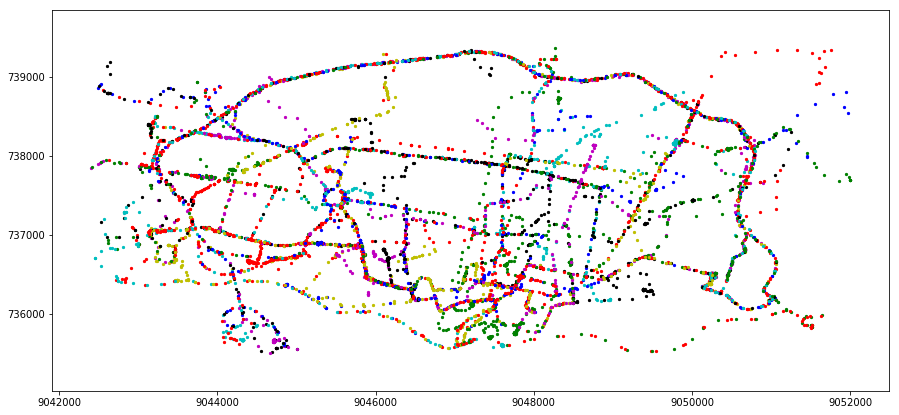

In [2]:
# loading trajectories and plotting them

a = open("trajectories/pkdd100-utm-box",'rb')
#a = open("trajectories/taxi500.txt",'rb')
trajectories = cPickle.load(a)
#[:100]
a.close()
noTraj = len(trajectories)

lsh.plotTrajectories(trajectories)
plt.show()

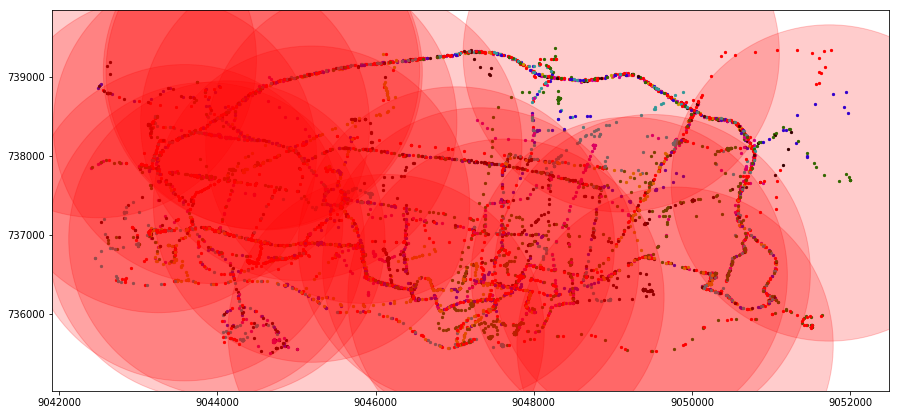

In [3]:
# n is the number of circles and Rs stores the lengths of each circle
# Rs should have length n

n = 20
Rs = np.repeat(2000,n) # all circles have the same radius
# Rs = random.sample(range(500,2000),n) # random sizes between 500 and 2000

circles = lsh.findCircles(trajectories, n)
lsh.plotTrajectories(trajectories)
lsh.plotCircles(circles, Rs)
plt.show()

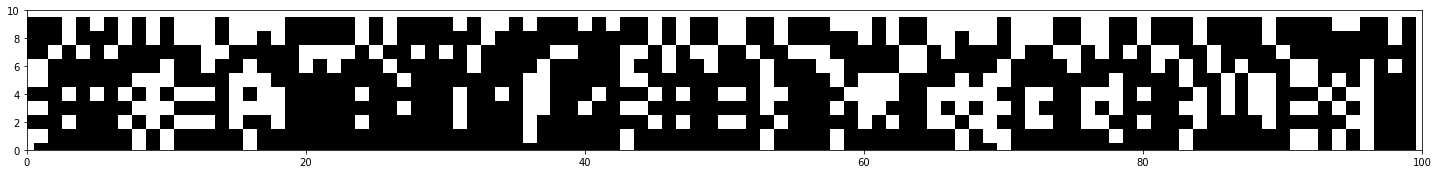

In [23]:
# computing the binary vectors for each trajectory

binary_vectors = lsh.binaryVectors(trajectories, circles, Rs)

# in the image every column is the binary representation of a trajectory

fig, ax = plt.subplots(figsize=(25,50))
ax.set_xlim([0, len(trajectories)])
ax.set_ylim([0, n])
plt.imshow(binary_vectors.transpose(), cmap='Greys')
plt.show()

In [24]:
# computing the distance between trajectories

cdist = lsh.makeCdist(trajectories, circles, binary_vectors)

# the plot shows the distance matrix
# white means the trajectories are equal under our distance

# fig, ax = plt.subplots(figsize=(25,25))
# ax.set_xlim([0, len(trajectories)])
# ax.set_ylim([0, len(trajectories)])
# plt.imshow(cdist, cmap='Blues')
# plt.show()

In [7]:
layers = 10
R = 2000
eps = 0.1
R_previous = R/(1-eps)
#A = (750000-735000)*(9065000-9035000)
A = (740000-735000)*(9052000-9042000)
#A = (4646000-4640000)*(295000-288000)
Rs = []
R_lengths = []
ns = []
for i in range(layers):
    R_current = R_previous*(1-eps)
    R_lengths.append(R_current)
    n_current = A/(R_current**2)*math.log(A/(R_current**2))/5
    ns.append(int(n_current))
    Rs.extend(np.repeat(R_current,n_current))
    R_previous = R_current
print(ns)
print(R_lengths)

R_lengths.append(0)

circles = lsh.findCircles(trajectories, len(Rs))
#lsh.plotTrajectories(trajectories)
#lsh.plotCircles(circles, Rs)
#plt.show()

[6, 8, 11, 14, 19, 25, 33, 43, 56, 73]
[2000.0, 1800.0, 1620.0, 1458.0, 1312.2, 1180.98, 1062.882, 956.5938000000001, 860.9344200000002, 774.8409780000002]


In [15]:
# for a trajectory give a dictionary where each key is a layer number
# and each value is the edit_vector for corresponding R

def edit_vector_layers(trajectory, cs, Rs, ns):
    vector_layers = dict()
    last_position = 0
    for i,n in enumerate(ns):
        current_position = last_position+n
        #print(last_position,current_position)
        vector_layers[i] = lsh.editVector([trajectory], cs[last_position:current_position], Rs[last_position:current_position])[0]
        last_position = current_position
    #print(vector_layers)
    return vector_layers

def edit_vector_layers_all(trajectories, cs, Rs, ns):
    all_vectors = []
    for trajectory in trajectories:
        all_vectors.append(edit_vector_layers(trajectory, cs, Rs, ns))
    return all_vectors

def compare_layers(edit_vector_layers_A, edit_vector_layers_B):
    layers_no = len(edit_vector_layers_A)
    for layer in range(layers_no):
        if lsh.levenshtein(edit_vector_layers_A[layer], edit_vector_layers_B[layer])>1:        
            #print(layer)
            return layer
    #print(layer)
    return layer+1

def find_last_layer(edit_vector_layers_A, edit_vector_layers_B):
    layers = len(edit_vector_layers_A)
    last_layer = 0
    for layer in range(layers):
        if lsh.levenshtein(edit_vector_layers_A[layer], edit_vector_layers_B[layer])<=1:        
            last_layer = layer
    return last_layer

In [ ]:
#fig, ax = plt.subplots(figsize=(15,10))
print(R_lengths)

last_layers = []
first_layers = []
hausdorffs = []
freches = []

frechet100 = cPickle.load(open( "frechet100-utm-box","rb"))
haus100 = cPickle.load(open( "haus100-utm-box","rb"))

count = 0
total = 0
for i in range(0,100):
    for j in range(0,100):
        a = edit_vector_layers(trajectories[i], circles, Rs, ns)
        b = edit_vector_layers(trajectories[j], circles, Rs, ns)
        #print(a,b)
        #lsh.plotTrajectories([trajectories[0],trajectories[2]])
        #fr = frechet.frechetDist(trajectories[i], trajectories[j])
        fr = frechet100[i][j]
        h = haus100[i][j]
        #h = haus.distanceBetweenCurves(trajectories[i], trajectories[j])
        first_layer = compare_layers(a,b)
        last_layer = find_last_layer(a,b)
        freches.append(fr)
        hausdorffs.append(h)
        last_layers.append(last_layer)
        first_layers.append(first_layer)
#         print("layer: ", layer)
#         minf = R_lengths[layer]/2
#         #minf = 0
#         if layer == 0:
#             maxf = 5000
#         else:
#             maxf = R_lengths[layer]
#         print(minf,maxf, R_lengths[layer-1], R_lengths[layer])
#         plt.plot([total,total],[minf,2*maxf],'-')
#         #plt.plot([total,total],[minf,2*minf],'-')
#         plt.scatter([total],[fr])
#         print("intervals: ", fr,minf, 2*maxf)
#         #print("intervals: ", fr, minf, 2*mif)
#         #if fr>=minf and fr<=2*maxf:
# #         if fr<5000:
# #             total +=1
# #             if fr>=minf and fr<=2*minf:
# #                 count+=1
#         if fr>=minf and fr<=2*maxf:
#             count+=1
#         total+=1

# plt.scatter(layers,distances)
# plt.show()
#print(count,total)

[2000.0, 1800.0, 1620.0, 1458.0, 1312.2, 1180.98, 1062.882, 956.5938000000001, 860.9344200000002, 774.8409780000002, 0]


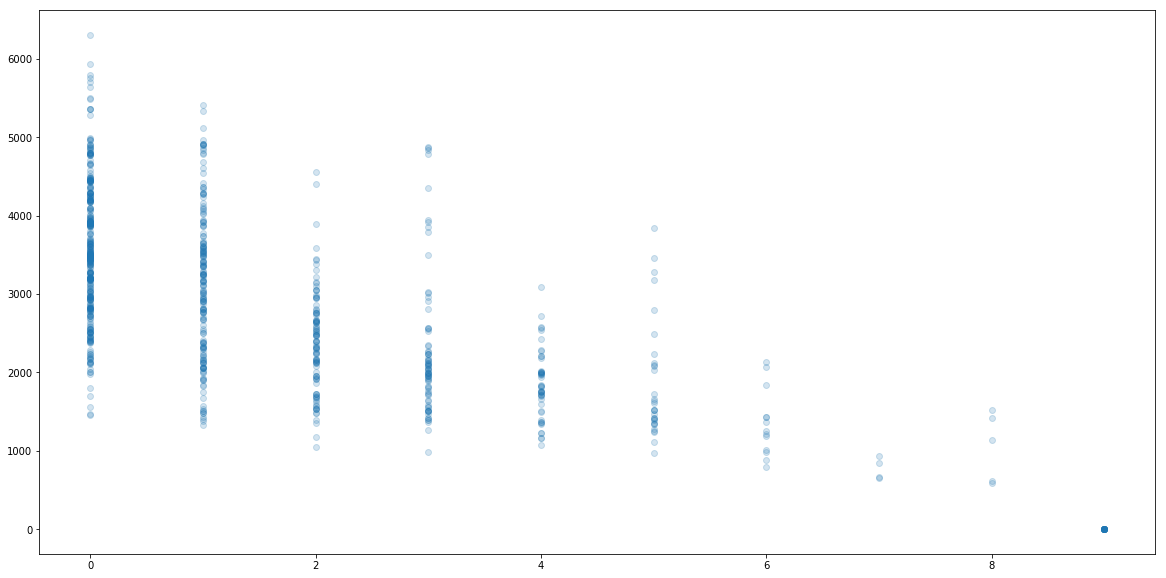

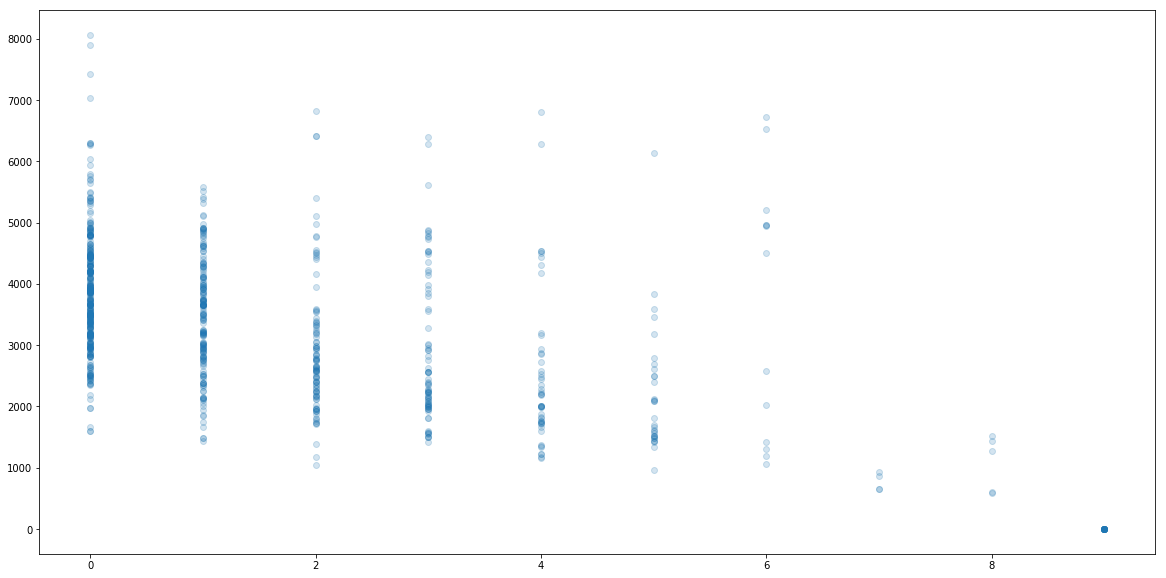

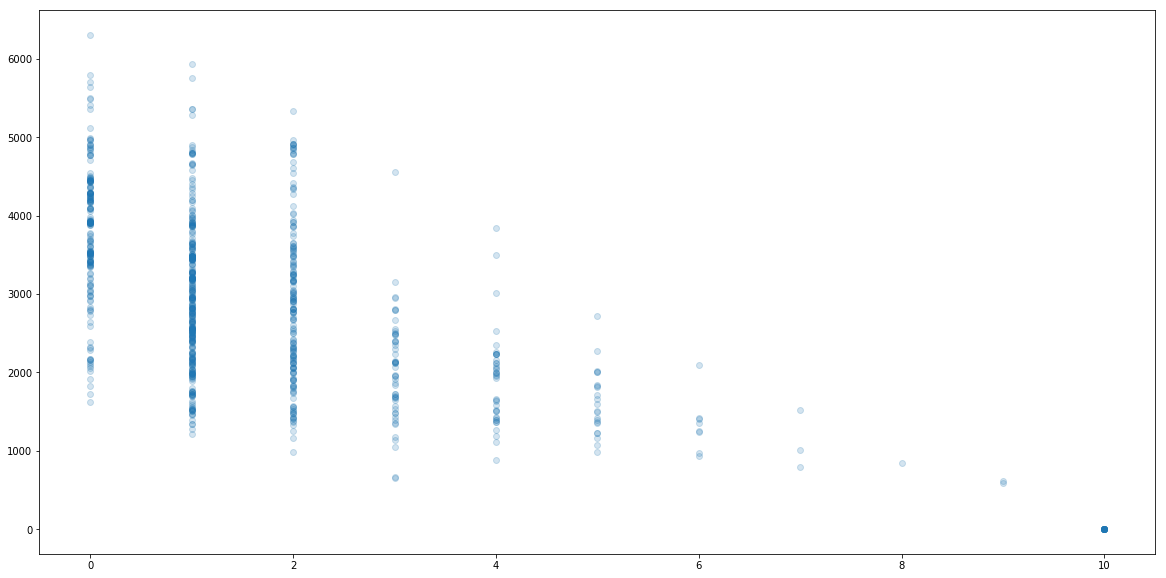

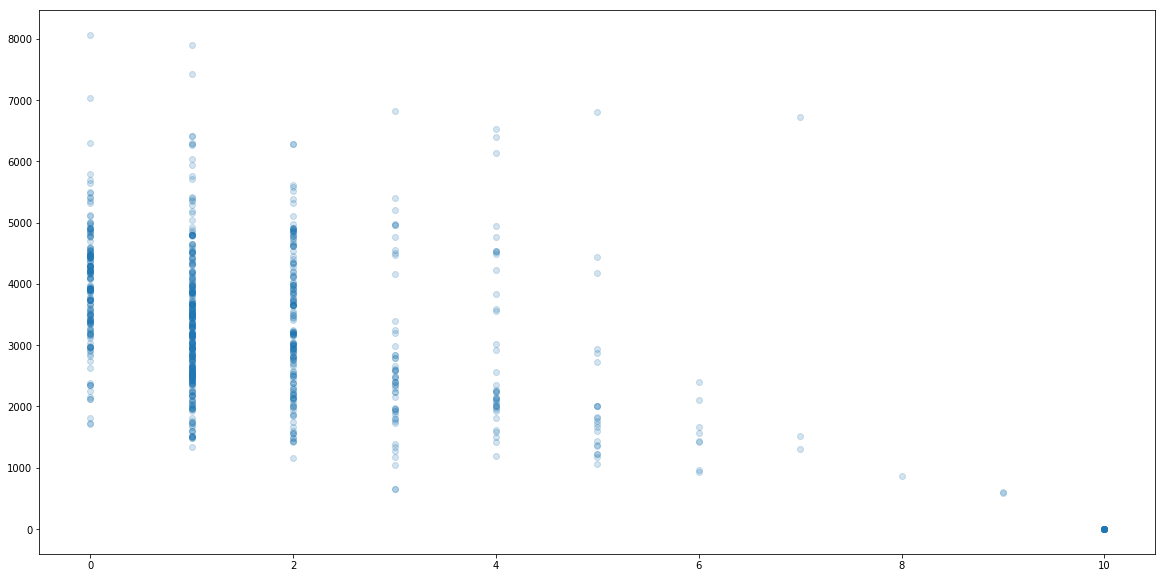

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
plt.scatter(last_layers,hausdorffs, alpha=0.1)
plt.show()
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(last_layers,freches, alpha=0.1)
plt.show()
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(first_layers,hausdorffs, alpha=0.1)
plt.show()
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(first_layers,freches, alpha=0.1)
plt.show()